In [1]:
from Vissim_env_class import environment
from Actor_critic_class import ACAgent
from MasterAC_Agent import MasterAC_Agent
from MasterDQN_Agent import MasterDQN_Agent

# Network Specific Libraries
from Balance_Functions import balance_dictionary

# General Libraries
import numpy as np 
import pylab as plt
import os
import shutil
import csv
import pandas as pd
import json

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Balance RL DQN Partial Training

In [2]:
model_name  = 'Balance_integrated'
vissim_working_directory = 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim\\'
#vissim_working_directory = "E:\\OneDrive - University of Warwick\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim"

# State the internal IDs of the intersections used during training, according to topology
intersection_ids = ["1_2_4", "1_2_4", "3", "1_2_4", "5", "6", "7",\
                    "8", "9", "10", "11_12", "11_12", "13", "14"]

## Simulation Parameters
Random_Seed = 44
sim_length = 9001
agent_type = "DDQN"
actions = 'default_actions'     # 'default_actions' or 'all_actions'

## DQN Hyperaramenters
episodes = 500
copy_weights_frequency = 10
timesteps_per_second = 1
PER_activated = True
memory_size = 5000
batch_size = 128
batches_per_episode = 10

alpha = 0.00005
gamma = 0.95

# Load balance dictionary
Balance_dictionary = balance_dictionary(agent_type)

# State session ID
Session_ID = model_name + "_" + actions + "_" + str(episodes) + "_" + str(sim_length-1) + "_" + agent_type
print("Session ID: {}".format(Session_ID))

Session ID: Balance_integrated_default_actions_500_9000_DDQN


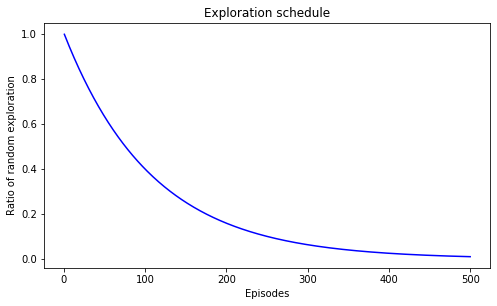

In [3]:
# Exploration Schedule ("linear" or "geometric")
exploration_schedule = "geometric"
epsilon_start = 1
epsilon_end   = 0.01

def choose_schedule(exploration_schedule, espilon_start, epsilon_end, episodes):
    if exploration_schedule == "linear":
        epsilon_decay = 1.2*(epsilon_end - epsilon_start)/(episodes-1)
        epsilon_sequence = [1 + epsilon_decay * entry for entry in range(episodes+1)]
        epsilon_sequence = [0.01 if entry < 0.01 else entry for entry in epsilon_sequence]
    elif exploration_schedule == "geometric":
        epsilon_decay = np.power(epsilon_end/epsilon_start, 1./(episodes-1)) # Geometric decay
        epsilon_sequence = [epsilon_start * epsilon_decay ** entry for entry in range(episodes+1)]
        epsilon_sequence = [0.01 if entry < 0.01 else entry for entry in epsilon_sequence]
    elif exploration_schedule == "entropy":
        pass
    else:
        print("ERROR: Unrecognized choice of exploration schedule.")
        
    # Plotting exploration schedule
    plt.figure(figsize=(8,4.5))
    x_series = np.array(range(1,episodes+1))
    y_series = epsilon_sequence[0:episodes]
    plt.plot(x_series, y_series, '-b')
    plt.xlabel('Episodes')
    plt.ylabel('Ratio of random exploration')
    plt.title('Exploration schedule')
    plt.show()
    return(epsilon_sequence)

epsilon_sequence = choose_schedule(exploration_schedule, epsilon_start, epsilon_end, episodes)


In [ ]:
## Gather files from pretrained Balance_intX Runs

# Re-create the Intersection IDs used during training
single_intersection_agent_ids = ['Balance_int'+ int_id for int_id in intersection_ids]
# Re-create the Session IDs used during training
single_intersection_session_ids = [ agent_id + "_" + actions + "_" + str(episodes) + "_" + str(sim_length-1) + "_" + agent_type
 for agent_id in single_intersection_agent_ids]

# Use the two previous set of strings to point to the location of the agent files
agents_sources_origin = [os.path.join(vissim_working_directory, single_intersection_agent_ids[idx],\
                                   "Agents_Results", agent_type, session_id) for idx, session_id in enumerate(single_intersection_session_ids)]

# Set the destination path into the new model
# Intersections that trained together are now split into individual forlders
agents_sources_destination = [os.path.join(vissim_working_directory, "Balance_Integrated", "Agents_source",\
                                         agent_type, Session_ID,"Agent{}".format(idx)) for idx, session_id in enumerate(single_intersection_session_ids)]

# Check if output folders exist, if they do not, then create them
for folder in agents_sources_destination:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Copy all training files from their origin to the Balance_integrated archive
for idx, (origin, destination) in enumerate(zip(agents_sources_origin, agents_sources_destination)):
    print("Agent {}".format(idx))
    #print("Listing files in:", origin)
    
    # List all files in origin folder
    files_in_folder = os.listdir(origin)
    print("Copying files...")
    
    # Copy them one by one
    for file in files_in_folder:
        shutil.copy(os.path.join(origin,file), destination)
print("All Files Successfully Copied.")

In [4]:
Balance_integrated_MultiDQN_Agents = MasterDQN_Agent(model_name, vissim_working_directory, sim_length, Balance_dictionary, actions,\
                gamma, alpha, agent_type, memory_size, PER_activated, batch_size, batches_per_episode, copy_weights_frequency, epsilon_sequence,\
                Random_Seed, timesteps_per_second, Session_ID, verbose = True)

INTERSECTION 0: SETTING UP AGENT
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 48)                432       
_________________________________________________________________
dense_1 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 147       
Total params: 5,283
Trainable params: 5,283
Non-trainable params: 0
_________________________________________________________________
Deployed instance of Double Deep Q Learning Agent(s) at Intersection 0

INTERSECTION 1: SETT

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_64 (Dense)             (None, 48)                192       
_________________________________________________________________
dense_65 (Dense)             (None, 48)                2352      
_________________________________________________________________
dense_66 (Dense)             (None, 48)                2352      
_________________________________________________________________
dense_67 (Dense)             (None, 2)                 98        
Total params: 4,994
Trainable params: 4,994
Non-trainable params: 0
_________________________________________________________________
Deployed instance of Double Deep Q Learning Agent(s) at Intersection 8

INTERSECTION 9: SETTING UP AGENT
Model: "model_18"

In [5]:
Balance_integrated_MultiDQN_Agents.load_isolated(500, best = True)

Loading Agents....
Independently Pre-Trained Agent 0, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 1, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 2, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 3, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 4, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 5, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 6, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 7, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 8, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 9, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 10, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 11, Architecture, Optimizer and Memory.
Success.
Independently Pre-T

In [7]:
Balance_integrated_MultiDQN_Agents.demo()

Working Directory set to: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Attempting to load Model File: Balance_integrated.inpx ...
Model File load process successful.
Simulation length set to 9001 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                COM SETUP COMPLETE                   *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 44
Deploying Network Parser...
Successful Network Crawl: Identified SignalControllers, Links, Lanes and Vehicle Inputs.

Setting Simulation mode to: demo
Starting Deployme

com_error: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147467259), None)